# NLP with Transfer learning 


In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [ ]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re
from bs4 import BeautifulSoup

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks"

#### loaded the data from cvs file to datafram using pandas and prints the info

In [ ]:
reviews = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"D:\ML\Internal DL\NLP\amazon-fine-food-reviews\Reviews.csv")
#check the info of the dataset
reviews.info()

####  list of columns name for the current data frame

In [ ]:
reviews.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

####  dropped all extra colums which we are not using in this assignment to keep the only data that required.

In [ ]:
#get only 2 columns - Text, Score
#drop the NAN values

reviews.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis = 1, inplace = True) 



####  dropped the rows which have empty cells given by 'na'

In [ ]:
reviews = reviews[reviews['Score'].notna()]
reviews = reviews[reviews['Text'].notna()]

In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   568454 non-null  int64 
 1   Text    568454 non-null  object
dtypes: int64(1), object(1)
memory usage: 13.0+ MB


#### converted the Score into binary (Positive / Negative) using the below logic.

           if score> 3, set score = 1

           if score<=2, set score = 0

           if score == 3, remove the rows. 

In [ ]:

reviews.drop(reviews[reviews['Score']== 3].index, inplace = True)
reviews.loc[reviews['Score'] <= 2, 'Score'] = 0
reviews.loc[reviews['Score'] > 3, 'Score'] = 1


In [ ]:
reviews  

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...
...,...,...
568449,1,Great for sesame chicken..this is a good if no...
568450,0,I'm disappointed with the flavor. The chocolat...
568451,1,"These stars are small, so you can give 10-15 o..."
568452,1,These are the BEST treats for training and rew...


In [ ]:
reviews.Score.value_counts()

1    443777
0     82037
Name: Score, dtype: int64

<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

####  preprocessed the Reviews['Text'] by removing all the html tags in the review using regeular expression.

In [ ]:

preprocessed_reviews=[]
for review in reviews['Text'].values:
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    review=re.sub(cleanr,' ',review)
    preprocessed_reviews.append(review)
#preprocessed_reviews
reviews['Text']=preprocessed_reviews

In [ ]:
reviews.head(5)

,Score,Text,len
64117,1,The tea was of great quality and it tasted lik...,30
418112,1,My cat loves this. The pellets are nice and s...,31
357829,1,Great product. Does not completely get rid of ...,41
175872,1,This gum is my favorite! I would advise every...,27
178716,1,I also found out about this product because of...,22


In [ ]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 


from sklearn.model_selection import train_test_split

X= reviews.drop(['Score'], axis = 1)
y= reviews['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=33,stratify=y)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

80000
20000
80000
20000


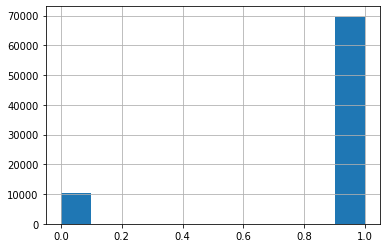

In [ ]:
y_train.hist()

####  Observation :: It can be seen from the above histogram that the training data contain mostly the positive reviews

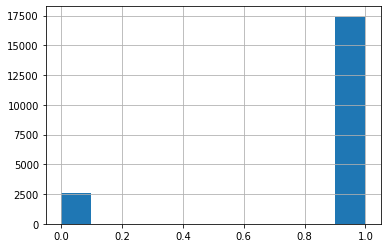

In [ ]:
#plot bar graphs of y_train and y_test
y_test.hist()

####  observation : Here I observed from the above histogram that the test data also contain most  the positive reviews.

In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed.csv', index=False)

In [ ]:
reviews = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/preprocessed.csv")

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
bert_model.output

<tf.Tensor 'keras_layer/StatefulPartitionedCall:0' shape=(None, 768) dtype=float32>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.1MB 9.2MB/s 


In [ ]:
#import tokenization - We have given tokenization.py file
from google.colab import files
src = list(files.upload().values())[0]
open('tokenization.py','wb').write(src)
import tokenization

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
import tokenization

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation
tokenizer=tokenization.FullTokenizer(vocab_file, do_lower_case )

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [ ]:
from itertools import repeat

#### The function convert_toToken() takes a review as input and performed below task:

1) It will convert the review into tokens using the Tokenizer.py

2)It will convert the tokenize review into fix sql length and add [CLS] at bigining and [SEP] tokens at the end of the review.

3) if tokenize review is less than the required length, we will add [PAD] tokens at the end of it.

4) Then will convert the tokens into id using the convert_tokens_to_ids().

5) After that create the mast array which will contain 1 for real token and 0 for [PAD] tokens.

6) Then also create the segment array with all 0's of the same size as max_seq_length

7)  return the tokenize input, mask array and segment array for each review.

In [ ]:
def convert_toToken(Review):

    segment = [0] * max_seq_length
    tokens = []
    mask = []

    tokens_a = tokenizer.tokenize(Review.Text)
    #print(len(tokens_a))
    if len(tokens_a) > max_seq_length-2:
      tokens_a = tokens_a[0 : (max_seq_length-2)]
      #print(len(tokens_a))

    tokens=["[CLS]",*tokens_a,"[SEP]"]         
    #print(tokens)
    temp=len(tokens)
    if len(tokens_a) < max_seq_length:
        tokens.extend(repeat('[PAD]',(max_seq_length-len(tokens))))

    mask=[1]*temp+[0]*(max_seq_length-temp)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    #print(mask)
    #print(len(tokens),len(mask),len(segment))
    #print("="*50)

    return token_ids, mask, segment

#### The function convert_dateset() takes a reviews dataframe as input and performed below task:

1) It will itrate each review in the dataframe and convert it into the token ids , Masks and segments using the convert_toTokens();



In [ ]:
def convert_dateset(Reviews):
  #print(len(Reviews))
  tokens, masks, segments = [], [], []
  #temp=reviews.head(15)
  for index, review in Reviews.iterrows():
    token, mask, segment = convert_toToken(review)
    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

  #print(len(tokens))
  #print(len(masks))
  #print(len(segments))

  return (
        np.array(tokens),
        np.array(masks),
        np.array(segments)
    )


In [ ]:
# Converting all the review in train and test data set
(X_train_tokens, X_train_mask, X_train_segment) =  convert_dateset(X_train)
(X_test_tokens, X_test_mask, X_test_segment) =  convert_dateset(X_test)


In [ ]:
print(len(X_train_tokens))
print(len(X_test_tokens))
print(len(X_train_segment))
print(len(X_test_segment))
print(len(X_train_mask))
print(len(X_test_mask))
print(len(X_train))
print(len(X_test))

80000
20000
80000
20000
80000
20000
80000
20000


#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
import pickle

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('/content/drive/My Drive/Colab Notebooks/train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('/content/drive/My Drive/Colab Notebooks/test_data.pkl','wb'))

In [ ]:
#you can load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open('/content/drive/My Drive/Colab Notebooks/train_data.pkl', 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open('/content/drive/My Drive/Colab Notebooks/test_data.pkl', 'rb')) 

In [ ]:
X_train_tokens

array([[ 101, 1996, 5572, ...,    0,    0,    0],
       [ 101, 2026, 4937, ...,    0,    0,    0],
       [ 101, 2307, 4031, ...,    0,    0,    0],
       ...,
       [ 101, 6581, 5572, ...,    0,    0,    0],
       [ 101, 2122, 1051, ...,    0,    0,    0],
       [ 101, 2023, 2003, ...,    0,    0,    0]])

<font size=4>Grader function 4 </font>

In [ ]:
def grader_alltokens_train():
    out = False
    
    if (type(X_train_tokens) == np.ndarray):
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 55) dtype=int32>]

In [ ]:
bert_model.output

<tf.Tensor 'keras_layer/StatefulPartitionedCall:0' shape=(None, 768) dtype=float32>

In [ ]:
X_test_tokens

array([[ 101, 2026, 6875, ..., 2009, 1012,  102],
       [ 101, 2009, 2001, ...,    0,    0,    0],
       [ 101, 2122, 9550, ...,    0,    0,    0],
       ...,
       [ 101, 2054, 1037, ...,    0,    0,    0],
       [ 101, 1996, 5572, ..., 2015, 1012,  102],
       [ 101, 1045, 2788, ..., 2000, 2031,  102]])

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('/content/drive/My Drive/Colab Notebooks/final_output.pkl','wb'))

In [ ]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('/content/drive/My Drive/Colab Notebooks/final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

### I build the Naural Network upon on BERT module to classify the reviews into positive and negative. Then added the dense layer over the bert module with 128 neurons with ReLu activtion.Then added one more layer with single Neuron with sigmoid activition. This layer will make the prediction.


In [ ]:
##create an NN and 
dense = tf.keras.layers.Dense(128, activation='relu')(bert_model.output)
pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)


model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                  metrics=['accuracy',tf.keras.metrics.AUC()]) 

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 55)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 55)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 55)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
import datetime
log_dir="/content/drive/My Drive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)

In [ ]:
y_train_1=y_train.to_numpy();
y_test_1=y_test.to_numpy()

In [ ]:
print(type(X_train_tokens))
print(type(X_train_mask))
print(type(X_train_segment))
print(type(X_test_tokens))
print(type(X_test_mask))
print(type(X_test_segment))
print(type(y_train))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [ ]:
model.fit(
    [X_train_tokens, X_train_mask, X_train_segment], 
    y_train,
    validation_data=([X_test_tokens, X_test_mask, X_test_segment], y_test),
    epochs=5,
    batch_size=8,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
    1/10000 [..............................] - ETA: 6s - loss: 0.8174 - accuracy: 0.2500 - auc: 0.6667WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


    2/10000 [..............................] - ETA: 21:52 - loss: 0.7829 - accuracy: 0.2500 - auc: 0.6667WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0588s vs `on_train_batch_end` time: 0.2069s). Check your callbacks.


 9999/10000 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.8917 - auc: 0.8836

InvalidArgumentError: ignored

In [ ]:
history=model.fit(
    [X_train_tokens, X_train_mask, X_train_segment], 
    y_train,
    validation_data=([X_test_tokens, X_test_mask, X_test_segment], y_test),
    epochs=5,
    batch_size=8,
    verbose=1,
    #callbacks=[tensorboard_callback]
)

Epoch 1/5
10000/10000 [==============================] - 414s 41ms/step - loss: 0.2048 - accuracy: 0.9154 - auc: 0.9336 - val_loss: 0.1936 - val_accuracy: 0.9208 - val_auc: 0.9421
Epoch 2/5
10000/10000 [==============================] - 412s 41ms/step - loss: 0.1950 - accuracy: 0.9196 - auc: 0.9397 - val_loss: 0.1856 - val_accuracy: 0.9250 - val_auc: 0.9457
Epoch 3/5
10000/10000 [==============================] - 413s 41ms/step - loss: 0.1882 - accuracy: 0.9235 - auc: 0.9437 - val_loss: 0.1846 - val_accuracy: 0.9284 - val_auc: 0.9461
Epoch 4/5
10000/10000 [==============================] - 413s 41ms/step - loss: 0.1850 - accuracy: 0.9249 - auc: 0.9460 - val_loss: 0.1816 - val_accuracy: 0.9288 - val_auc: 0.9489
Epoch 5/5
10000/10000 [==============================] - 414s 41ms/step - loss: 0.1830 - accuracy: 0.9258 - auc: 0.9471 - val_loss: 0.1796 - val_accuracy: 0.9276 - val_auc: 0.9494


In [ ]:
model.fit(
    [X_train_tokens, X_train_mask, X_train_segment], 
    y_train,
    validation_data=([X_test_tokens, X_test_mask, X_test_segment], y_test),
    epochs=5,
    batch_size=8,
    verbose=1,
    #callbacks=[tensorboard_callback]
)

Epoch 1/5
10000/10000 [==============================] - 414s 41ms/step - loss: 0.1807 - accuracy: 0.9270 - auc: 0.9485 - val_loss: 0.1858 - val_accuracy: 0.9256 - val_auc: 0.9500
Epoch 2/5
10000/10000 [==============================] - 413s 41ms/step - loss: 0.1789 - accuracy: 0.9269 - auc: 0.9495 - val_loss: 0.2021 - val_accuracy: 0.9180 - val_auc: 0.9492
Epoch 3/5
10000/10000 [==============================] - 413s 41ms/step - loss: 0.1776 - accuracy: 0.9281 - auc: 0.9501 - val_loss: 0.1744 - val_accuracy: 0.9319 - val_auc: 0.9511
Epoch 4/5
10000/10000 [==============================] - 414s 41ms/step - loss: 0.1763 - accuracy: 0.9283 - auc: 0.9511 - val_loss: 0.1786 - val_accuracy: 0.9311 - val_auc: 0.9526
Epoch 5/5
10000/10000 [==============================] - 413s 41ms/step - loss: 0.1753 - accuracy: 0.9291 - auc: 0.9518 - val_loss: 0.1800 - val_accuracy: 0.9277 - val_auc: 0.9517


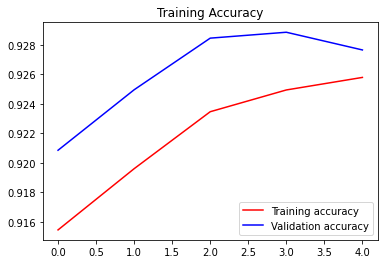

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training Accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

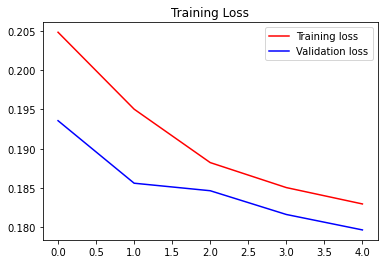

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training Loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/Bert_Model.h5")
print("Saved model to disk")

Saved model to disk


### Observation : From above logs and diagram, we can see that, when I have trained the model for 10 epoch, the accuracy  has reached upto the 92% and the validation accuracy  is also reached 92%. Both accuracy  and validation accuracy incresing slightly in same direction shows that model is not overfitting or underfitting. We can also see the loss and validation loss going down with each epoch.

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [ ]:
test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv",)

test_data.head()

print(len(test_data))

352


In [ ]:
test_data['Text'] = test_data['Text'].map(lambda x: re.sub(r'<.*?>', '', x))

In [ ]:
(test_tokens, test_mask, test_segment) =  convert_dateset(test_data)

In [ ]:
test_pooled_output=bert_model.predict([test_tokens,test_mask,test_segment])

In [ ]:
test_pooled_output.shape

(352, 768)

In [ ]:
test_predictions = model.predict(x=[test_tokens, 
                                    test_mask, 
                                    test_segment],
                                 batch_size=10,
                                 verbose=1)

 2/36 [>.............................] - ETA: 1sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0103s vs `on_predict_batch_end` time: 0.0485s). Check your callbacks.


36/36 [==============================] - 1s 39ms/step


In [ ]:
test_predictions = test_predictions.ravel()
test_pred_labels = [1 if prob > 0.5 else 0 for prob in test_predictions]

In [ ]:
print("Number of predictions for 1=",test_pred_labels.count(1))
print("Number of predictions for 0=",test_pred_labels.count(0))

Number of predictions for 1= 318
Number of predictions for 0= 34


### Observaion : After testing the model I have created with new 352 reviews , the model has predicted the 318 reviews as positive and only 34 as negative. Similar kind of patten has seen when I was spliting the data into test and train. Both the test and train data has most of the reviews as positive. So to avaid the model bais towards one class, we should have the data which has split into the equal proportions for all the targert which we wish to predict. 